#Integrated Gradients, GradientShap, Occlusion, NoiseTunnel

This Jupyter Notebook starts by importing the necessary Python libraries such as Torch, Torchvision, PIL, requests, NumPy, and Captum. It then loads the VGG11 pre-trained model and sets it to evaluation mode.

Next, it defines a transformation pipeline for the input image which includes resizing, center cropping, and converting the image to a tensor. It also normalizes the image using mean and standard deviation values specific to the ImageNet dataset. The input image is then loaded and transformed.

The notebook uses three different attribution methods, Integrated Gradients, GradientShap, and Occlusion, to generate attribution maps to understand the contribution of different regions of the image towards the model's output.

Finally, it computes the attribution maps for the input image using these three methods and visualizes the results using Captum's visualization functions. Additionally, it uses the NoiseTunnel class to smooth the attribution maps generated by Integrated Gradients.

The goal of this notebook is to provide a basic understanding of the different attribution methods available in Captum and to showcase how to use them to analyze the contribution of different parts of an input image towards a model's output.

This Jupyter notebook is based on:

* https://captum.ai/tutorials/CIFAR_TorchVision_Interpret  
* https://captum.ai/tutorials/Resnet_TorchVision_Interpret
* https://captum.ai/docs/attribution_algorithms#integrated-gradients
* https://captum.ai/docs/attribution_algorithms#gradient-shap
* https://captum.ai/docs/attribution_algorithms#occlusion
* https://captum.ai/docs/attribution_algorithms#noise-tunnel
* https://arxiv.org/abs/1703.01365
* https://proceedings.neurips.cc/paper_files/paper/2017/hash/8a20a8621978632d76c43dfd28b67767-Abstract.html
* https://github.com/slundberg/shap/#deep-learning-example-with-gradientexplainer-tensorflowkeraspytorch-models
* https://arxiv.org/abs/1311.2901
* https://github.com/marcoancona/DeepExplain/blob/master/deepexplain/tensorflow/methods.py
* https://arxiv.org/abs/1706.03825  

#### Installing Captum Library

The following line installs version 0.6.0 of the Captum library.

This version is used because it is compatible with the other libraries used in this notebook.

In [1]:
!pip install matplotlib==3.6 captum==0.6.0

#### Configuring Matplotlib for Displaying Images

The following line configures Matplotlib to display images without padding.

This configuration is necessary because Matplotlib adds padding around images by default, which can affect the layout of the notebook. Setting the `bbox_inches` parameter to `None` removes the padding and ensures that images are displayed at their original size without any cropping or scaling.

In [2]:
%config InlineBackend.print_figure_kwargs={'bbox_inches':None}

#### Using Integrated Gradients, GradientShap, Occlusion, NoiseTunnel
This cell imports necessary libraries and loads a pre-trained VGG11 model for image classification. It applies different attribution methods like Integrated Gradients, GradientShap, and Occlusion to visualize important features of an input image for classification. The script also checks if a GPU is available, defines a baseline for some attribution methods, and smoothens the attribution maps using NoiseTunnel.

In [3]:
import torch
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
from captum.attr import visualization as viz
from captum.attr import IntegratedGradients, GradientShap, Occlusion, NoiseTunnel
from matplotlib.colors import LinearSegmentedColormap

# Check if GPU is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using device:', device)

# Load the model and set it to evaluation mode
model = models.vgg11(pretrained=True)
model.to(device)
model.eval()

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

transform_normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

img = Image.open('/content/drive/MyDrive/Colab Notebooks/images/green_traffic_light.jpg')

transformed_img = transform(img)

input_img = transform_normalize(transformed_img)
input_img = input_img.unsqueeze(0)
input_img = input_img.to(device)

# Define the baseline for Integrated Gradients and GradientShap
baseline = torch.zeros_like(input_img)

# Define the IntegratedGradients, GradientShap, and Occlusion attribution methods
ig = IntegratedGradients(model)
nt = NoiseTunnel(ig)

# Compute the attribution maps using Integrated Gradients, GradientShap, and Occlusion
target = torch.argmax(model(input_img))
print(target)

with torch.no_grad():
    attr_ig = ig.attribute(input_img, baseline, target=target)
    # Use NoiseTunnel to smooth the attribution maps
    attr_ig_smooth = nt.attribute(input_img, nt_type='smoothgrad', nt_samples=3, stdevs=0.1, target=target)

Using device: cpu


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


tensor(920)


#### Visualization

Using different attribution methods to generate heat maps of the image that highlight regions that were most important for a given prediction made by the pre-trained VGG11 model. The resulting attribution maps are visualized with a color map and a color bar, and each map is given a title corresponding to the method used.

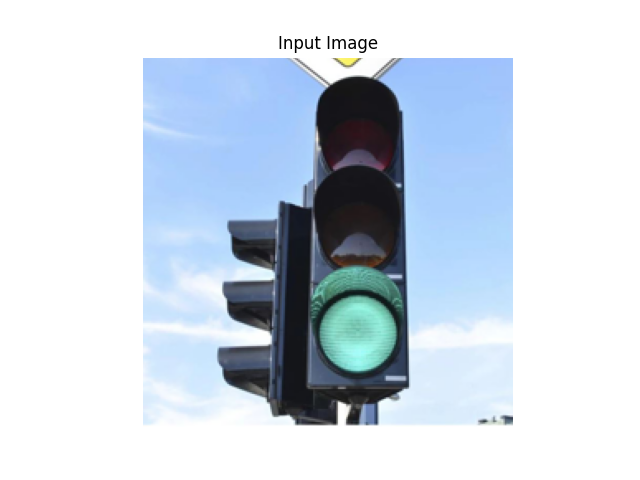

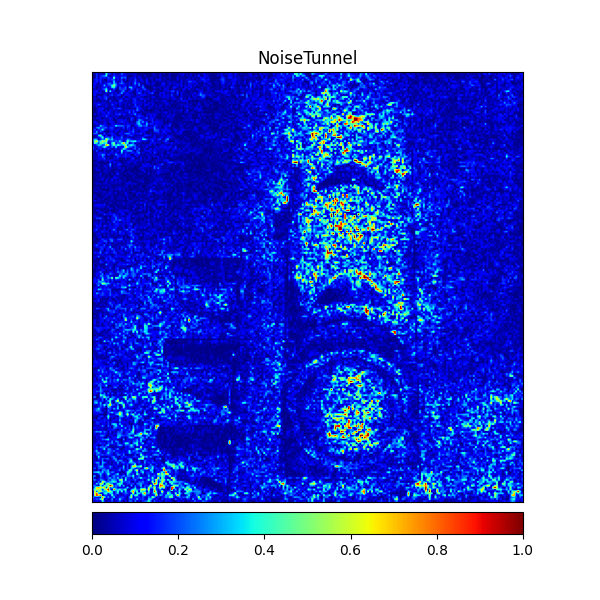

In [5]:
plt.axis('off')
plt.imshow(img.resize((224, 224)))
plt.title('Input Image')
plt.show()

# Visualize the attribution maps
_ = viz.visualize_image_attr(np.transpose(attr_ig_smooth.squeeze().cpu().detach().numpy(), (1,2,0)), show_colorbar=True, title='NoiseTunnel', method="heat_map", cmap='jet')